<a href="https://colab.research.google.com/github/r-doz/PML2025/blob/main/./Homeworks/Homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 2

Probabilistic Machine Learning -- Spring 2025, UniTS

### Problem 1: Marginal Likelihood Optimisation

Given the Bayesian Linear Regression model implemented in the Notebook 6, considering the same dataset and variables (Apparent Temperature vs Humidity), optimize alpha and beta by maximizing the Marginal Likelihood.

Note: You can show here only the piece of code that you used and write the optimal alpha and beta that you obtained (so you can run it in directly on Notebook 6)

Hint: import scipy.optimize as optimize

### Problem 2: Rejection Sampling

Consider the unnormalized probability density function:

$$
\tilde{p}(x) = \exp\left(-\frac{x^4}{4} - \frac{x^2}{2}\right)
$$

This density is defined for $x \in \mathbb{R}$, but it is not normalized. Let $Z$ be its normalization constant:

$$
Z = \int_{-\infty}^{\infty} \tilde{p}(x)\, dx
$$

You are given access to a proposal distribution $q(x) = \mathcal{N}(0, 1)$ from which you can sample and evaluate its density.

-  Implement and then use rejection sampling with $q(x)$ to generate samples from the normalized target distribution $p(x) = \frac{1}{Z} \tilde{p}(x)$.
    
- Estimate the normalization constant $Z$ (hint: see your course notes!)

- Compare your result with a numerical approximation of $Z$ using integration methods (e.g., scipy.integrate.quad).


In [46]:
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad

non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non entrato
non 

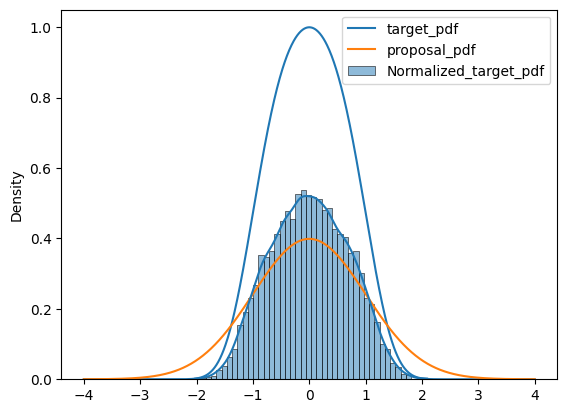

In [48]:
def rejection_sampling(target_pdf, proposal_pdf, proposal_sampler, n_samples):
    samples = []
    max_ratio = max(target_pdf(x) / proposal_pdf(x) for x in np.arange(-10, 10, 0.01)) # Adjust range as per your distribution
    #print(f"max_ratio: {max_ratio}")
    i =0 
    
    while len(samples) < n_samples:
        x = proposal_sampler()  # Sample from proposal distribution
        #print(f"x numero: {i+1}")
        i = i + 1
        u = np.random.uniform(0, max_ratio * proposal_pdf(x))
        
        if u <= target_pdf(x):
            #print('entrato')
            samples.append(x)
        else:
            print('non entrato')

    print(i)
    P_accepted = 1 - (i - len(samples)) / i
    print(f"Probability of being accepted: {P_accepted}")
    print(f"partition function: {P_accepted * max_ratio}")


    return samples

# Example usage:
def target_pdf(x):
    return np.exp((-x**4/4) - (x**2/2))    # Example target distribution, e.g., Gaussian
def proposal_pdf(x):
    return norm.pdf(x, loc=0, scale=1)    # Example proposal distribution, e.g., Exponential

samples = rejection_sampling(target_pdf, proposal_pdf,  np.random.normal, n_samples=10000)

Z, error = quad(target_pdf, -np.inf, np.inf)

print("Valore dell'integrale Z:", Z)
print("Errore stimato:", error)

x = np.linspace(-4, 4, 1000)
plt.plot(x, target_pdf(x), label="target_pdf")
plt.plot(x, proposal_pdf(x), label="proposal_pdf")
#plt.plot(x, 18.521616940414205 * proposal_pdf(x), label="proposal_pdf (norm)")
_ = sns.histplot(samples, kde=True, stat='density', label='Normalized_target_pdf')
_ = plt.legend()

In [38]:
print(len(samples))

10000


### Problem 3: MCMC Convergence Diagnostics

You have implemented a Metropolis-Hastings algorithm and used it to draw samples from a univariate target distribution. In this exercise, you will compute convergence diagnostics from scratch to assess whether your chains have mixed well.

Consider 4 parallel chains, each of length $N$ (after burn-in), starting from different initial values (use
initial_values = [-10, -2, 2, 10]). The unnormalized probability density function $\tilde{p}(x)$ is defined as a mixture of two Gaussian distributions:

$$
\tilde{p}(x) = \mathcal{N}(x; -5, 1) + \mathcal{N}(x; 5, 1)
$$

Perform the following steps two times, considering a proposal standard deviation of 0.1 and 2.0:

- Compute the within variance $W$ and the between variance $B$
- Compute the statistics $\hat{R}$
- For a single chain of samples $x_1, x_2, \dots, x_N$, compute the lag-$k$ autocorrelation $\rho_k$ and plot $\rho_k$ for $k = 1, 2, \dots, 20$
- Estimate the effective number of samples $n_{eff}$

Repeat the analysis with the distribution:

$$
\tilde{p}(x) = \mathcal{N}(x; -2, 1) + \mathcal{N}(x; 2, 1)
$$

Discuss the results



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
import torch
import seaborn as sns

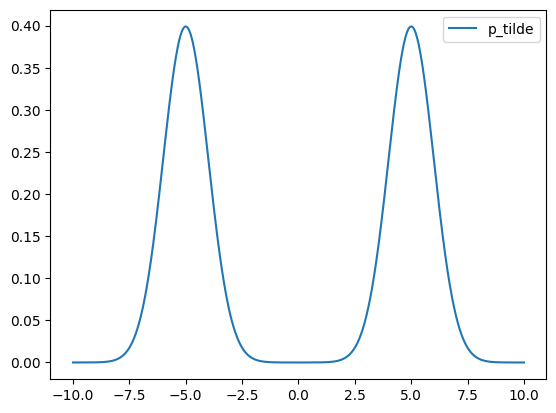

In [9]:
def sample_from_q(x, sigma):
    #your code here
    return np.random.normal(x, sigma)

def q_y_given_x(y, x, sigma):
    #your code here
    return stats.norm(x, sigma).pdf(y)

def p_tilde(x):
    #your code here
    return stats.norm(-5, 1).pdf(x) + stats.norm(5, 1).pdf(x) 

def metropolis_hastings(x_go, n, sigma):
    rejections = 0
    x = np.zeros(n)
    x[0] = x_go
    print(f"Inizio da x[0] = {x[0]}")
    for i in range(1, n):
        current_x = x[i-1]
        y = sample_from_q(current_x, sigma)

        print(f"\nStep {i}:")
        print(f"  Proposto y = {y}")
        print(f"  Punto attuale x = {current_x}")

        alpha = min(1., p_tilde(y)/ p_tilde(current_x) * q_y_given_x(current_x, y, sigma) / q_y_given_x(y, current_x, sigma))

        print(f"alpha: {alpha} \n 1^:{ p_tilde(y)/ p_tilde(current_x)} \n 2^: = {q_y_given_x(current_x, y, sigma) }   { q_y_given_x(y, current_x, sigma)}")

        if np.random.rand()  < alpha:
            print("  >>> Accettato")
            x[i] = y
        else:
            print("  >>> Rifiutato")
            x[i] = current_x
            rejections += 1

    
    return x, rejections

t = np.linspace(-10, 10, 1000)
plt.plot(t, p_tilde(t), label='p_tilde')
plt.legend()
plt.show()

In [14]:
sigma = 0.1
burn_in = 500 # number of samples to discard before collecting data
n = 1000

x_1,r_1 = metropolis_hastings(-10, n, sigma)
x_2,r_2 = metropolis_hastings(-2, n, sigma)
x_3,r_3 = metropolis_hastings(2, n, sigma)
x_4,r_4 = metropolis_hastings(10, n, sigma)

x_1 = x_1[burn_in:]
x_2 = x_2[burn_in:]
x_3 = x_3[burn_in:]
x_4 = x_4[burn_in:]

# print('x:', len(x))
# print('Rejection rate:', r)


Inizio da x[0] = -10.0

Step 1:
  Proposto y = -9.984411225312773
  Punto attuale x = -10.0
alpha: 1.0 
 1^:1.080930634272877 
 2^: = 3.9412426420863853   3.9412426420863853
  >>> Accettato

Step 2:
  Proposto y = -9.887776545061062
  Punto attuale x = -9.984411225312773
alpha: 1.0 
 1^:1.6112299868141489 
 2^: = 2.5011071364471147   2.5011071364471147
  >>> Accettato

Step 3:
  Proposto y = -9.992189123355333
  Punto attuale x = -9.887776545061062
alpha: 0.5970249677429139 
 1^:0.5970249677429139 
 2^: = 2.313004281915622   2.313004281915622
  >>> Rifiutato

Step 4:
  Proposto y = -9.831492634349903
  Punto attuale x = -9.887776545061062
alpha: 1.0 
 1^:1.3145826506658682 
 2^: = 3.4050261843491483   3.4050261843491483
  >>> Accettato

Step 5:
  Proposto y = -9.853826345430237
  Punto attuale x = -9.831492634349903
alpha: 0.8974888717080676 
 1^:0.8974888717080676 
 2^: = 3.891158107211144   3.891158107211144
  >>> Accettato

Step 6:
  Proposto y = -9.863661735534421
  Punto attuale x

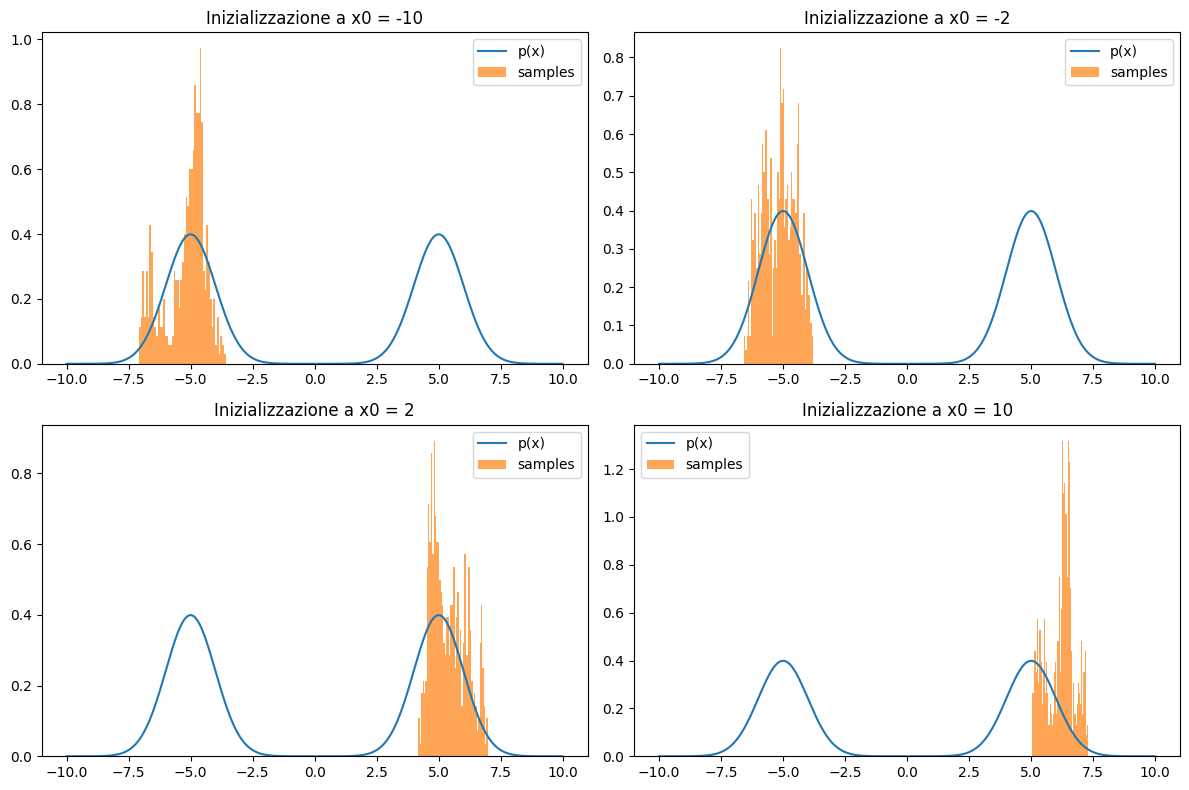

In [15]:

fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 righe, 2 colonne

axs[0, 0].plot(t, p_tilde(t), label='p(x)')
axs[0, 0].hist(x_1, bins=50, density=True, alpha=0.7, label='samples')
axs[0, 0].set_title('Inizializzazione a x0 = -10')
axs[0, 0].legend()

axs[0, 1].plot(t, p_tilde(t), label='p(x)')
axs[0, 1].hist(x_2, bins=50, density=True, alpha=0.7, label='samples')
axs[0, 1].set_title('Inizializzazione a x0 = -2')
axs[0, 1].legend()

axs[1, 0].plot(t, p_tilde(t), label='p(x)')
axs[1, 0].hist(x_3, bins=50, density=True, alpha=0.7, label='samples')
axs[1, 0].set_title('Inizializzazione a x0 = 2')
axs[1, 0].legend()

axs[1, 1].plot(t, p_tilde(t), label='p(x)')
axs[1, 1].hist(x_4, bins=50, density=True, alpha=0.7, label='samples')
axs[1, 1].set_title('Inizializzazione a x0 = 10')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

### Problem 4: ADSAI football matches
Over the years, the PhD students of ADSAI have kept track of the results of their evening five-a-side football matches. Since it’s difficult to always organize teams with the same players, the teams were formed on a rotating basis, each time with different players.  
The names of our champions have been anonymized using numbers from 1 to 62.  
In the dataset located at `data/ADSAI_football.csv` in the GitHub repository, you will find the following columns:
- **Team A**: IDs of the players who played in Team A in that match;  
- **Team B**: same as above, for Team B;  
- **Goal A**: total goals scored by Team A in that match;  
- **Goal B**: same as above, for Team B.



Your goal is to model **the skill of each player** based on information about the team they belonged to and the overall result achieved by that team.



The model to implement consists in the following structure: 
- $ \theta = (\theta_1, \theta_2, \dots, \theta_{62}) \in \mathbb{R} $: players' skills.
- $M=54$: number of matches.
- For each match $ i = 1, \dots, M=54$:
  - $ A_i \subset \{1, \dots, N=62\} $: set of players IDs of team A in match $ i $.
  - $ B_i \subset \{1, \dots, N=62\} $: set of players IDs of team B in match $ i $.
  - $ y_i \in \mathbb{Z} $: observed outcome, i.e. goal difference between the two teams, defined as $ (\text{goal}_A - \text{goal}_B) $ in match $ i $.

*(in this exercise, you are asked to follow the proposal of Karlis and Ntzoufras approach, that focuses on the goal difference in place of the individual goal counts of each team!)*



The model is defined as follows:

- The "strength" of Team A, defined as the sum of the individual players' skills $\theta_j$ composing the team in match $i = 1, \dots, M=54$:  
  $$
  s_A^{(i)} = \sum_{j \in A_i} \theta_j
  $$

- The "strength" of Team B, defined similarly as the sum of the individual players' skills $\theta_j$ composing the team in match $i = 1, \dots, M=54$:  
  $$
  s_B^{(i)} = \sum_{j \in B_i} \theta_j
  $$

Specifically, the observed goal difference in match $i$ is modeled using a Skellam distribution:  
$$
y_i \sim \text{Skellam}(\lambda_A^{(i)}, \lambda_B^{(i)}), \quad \text{where} \quad \lambda_A^{(i)} = \exp(s_A^{(i)}), \quad \lambda_B^{(i)} = \exp(s_B^{(i)})
$$

The **Skellam distribution** models the difference between two independent random variables:  
$$
\text{Skellam}(\lambda_A, \lambda_B) = \text{Poisson}(\lambda_A) - \text{Poisson}(\lambda_B)
$$
It is formally defined as:  
$$
\text{Skellam}(k; \lambda_A, \lambda_B) = e^{-(\lambda_A + \lambda_B)} \left( \frac{\lambda_A}{\lambda_B} \right)^{k/2} I_{|k|}(2 \sqrt{\lambda_A \lambda_B})
$$

for each $ k \in \mathbb{Z} $, and $ I_k $ is the modified Bessel function of the first kind of order $ k $.

$$
I_k(z) = \sum_{m=0}^\infty \frac{1}{m! \, \Gamma(m + k + 1)} \left( \frac{z}{2} \right)^{2m + k}
$$

where $\Gamma$ is the Gamma function.


In [2]:
#import only relevant quantities as follows:

import pandas as pd
import ast
import torch

def preprocessing_dataset(dataset_path='ADSAI_football.csv'):
    football = pd.read_csv(dataset_path)
    football['Team A'] = football['Team A'].apply(ast.literal_eval)
    football['Team B'] = football['Team B'].apply(ast.literal_eval)

    max_player_id = max(
    max(p for team in football['Team A'] for p in team),
    max(p for team in football['Team B'] for p in team)
    )

    goal_diff = torch.tensor((football['Goal A'] - football['Goal B']).values, dtype=torch.int)

    teams_A = [torch.tensor(team) for team in football['Team A']]
    teams_B = [torch.tensor(team) for team in football['Team B']]

    return teams_A, teams_B, goal_diff, max_player_id


teams_A, teams_B, goal_diff, max_player_id = preprocessing_dataset()




You are asked to: 
1. Find the MAP estimate for $ \theta = (\theta_1, \theta_2, \dots, \theta_{62})$ choosing as `log_prior` function a (log-)Standard Normal distribution and as `log_likelihood` function the (log-)Skellam. Perform optimization using Gradient Descent. Use the MAP estimate to implement a Laplace approximation of the posterior, as done during the lab (reuse the function `compute_hessian(f, w)` of Notebook 6).

**Important Hint:** The Skellam log-likelihood involves the modified Bessel function $I_k(z)$, which is non-differentiable in PyTorch if evaluated via scipy. To preserve differentiability, replace $\log I_k(z)$ with a smooth approximation, such as an asymptotic expansion, to allow gradient-based optimization.

2. **(Useful for the next point, not strictly necessary for the previous one):** Implement your `Skellam` distribution, inheriting from `torch.distributions.Distribution`;
3. Write the Pyro model corresponding to the problem depicted above assuming (again) the `theta` values being distributed initially as a Standard Normal;
4. Perform inference on $ \theta = (\theta_1, \theta_2, \dots, \theta_{62})$ values running a MCMC simulation using the `NUTS` kernel;
5. Compare the `theta` values obtained by these two options using the `performances_evaluation` function given in this notebook.


In [ ]:

# 1. Find the MAP estimate for $ \theta = (\theta_1, \theta_2, \dots, \theta_{62})$ choosing as `log_prior` function a (log-)Standard Normal distribution and as `log_likelihood` function the (log-)Skellam. Perform optimization using Gradient Descent;

def log_likelihood(teams_A, teams_B, goal_diff, theta):
    # TODO
    return ...

def log_prior(theta):
    # TODO
    return ...

def loss_function(theta):
    # TODO 
    return ...

def gradient_descent_optimization(loss_function, lr: float, n_iter: int, initial_guess: torch.Tensor):
    # TODO
    return ...

def compute_hessian(f, w):
    # TODO
    return ...

# here we want to obtain 
theta_MAP = ...
posterior_cov = ...


In [ ]:
#Visualize the marginal distribution of some thetas

import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

# Sample from the full posterior
mvn = MultivariateNormal(loc=theta_MAP, covariance_matrix=torch.from_numpy(posterior_cov).float())
posterior_samples = mvn.sample((1000,)) 

# Indices of thetas you want to visualize
selected_indices = [0, 1, 2, 20]  # Change these to the indices you're interested in

# Plot histograms
plt.figure(figsize=(10, 6))
for i, idx in enumerate(selected_indices):
    plt.subplot(2, 2, i + 1)
    plt.hist(posterior_samples[:, idx].numpy(), bins=40, density=True, alpha=0.7)
    plt.title(f"Posterior of $\\theta_{{{idx}}}$")
    plt.xlabel("Value")
    plt.ylabel("Density")
plt.tight_layout()
plt.show()


In [ ]:
# 2. Implement your `Skellam` distribution, inheriting from `torch.distributions.Distribution`;

import torch
import pyro

class Skellam(torch.distributions.Distribution):
    arg_constraints = ...

    def __init__(self, lambdaA, lambdaB, validate_args = None):
        self.lambdaA = lambdaA
        self.lambdaB = lambdaB
        batch_shape = torch.broadcast_shapes(lambdaA.shape, lambdaB.shape)
        super().__init__(batch_shape, validate_args=validate_args)

    def sample(self, sample_shape=torch.Size()):
        # Approximate sampling: sample two Poisson and subtract
        # TODO
        return ...
    
    def log_prob(self, value):
        # Exact log probability
        return ...
   

In [ ]:
 
# 3. Write the Pyro model corresponding to the problem depicted above assuming (again) the `theta` values being distributed initially as a Standard Normal;

def model(goal_diff, teams_A, teams_B, max_player_id):
    # TODO
    ...
   

In [ ]:
 
# 4. Perform inference on $ \theta = (\theta_1, \theta_2, \dots, \theta_{62})$ values running a MCMC simulation using the `NUTS` kernel;

from pyro.infer import MCMC, NUTS

# TODO

theta_MCMC = ...

In [ ]:

# 5. Compare the `theta_*` values obtained by these two options using the `performances_evaluation` function given in this notebook.

import numpy as np
import torch

def predict_goal_diff_skellam(teamA_ids, teamB_ids, theta, n_sim=10_000, posterior_cov=None):
    """
    Predicts the goal difference (Skellam distribution) between two teams using theta.

    Args:
        teamA_ids (list): Indices of the players in team A.
        teamB_ids (list): Indices of the players in team B.
        theta (torch.Tensor): Tensor containing the skill levels of the players.
        n_sim (int): Number of simulations to run.

    Returns:
        float: Mean predicted goal difference (A - B).
    """

    # Calculate the total strength for each team (sum of player skill levels)
    sA = theta[teamA_ids].sum()
    sB = theta[teamB_ids].sum()

    # Lambda parameters for Poisson distribution (expected goals)
    lam_A = torch.exp(sA).item()  # Team A's expected goal rate
    lam_B = torch.exp(sB).item()  # Team B's expected goal rate

    # Simulate goals for each team using Poisson distribution
    goals_A = np.random.poisson(lam_A, size=n_sim)
    goals_B = np.random.poisson(lam_B, size=n_sim)

    # Calculate the difference in goals (A - B)
    diff = goals_A - goals_B

    # Return the mean predicted difference
    return diff.mean()


def predict_goal_diff_laplace(teamA_ids, teamB_ids, theta_map, cov_matrix, n_sim=1000):
    # Combine all relevant indices
    all_ids = torch.tensor(sorted(set(teamA_ids) | set(teamB_ids)))

    # Extract subvector of means (mu_A and mu_B)
    theta_sub = theta_map[all_ids].float()

    # Extract submatrix of covariances
    cov_sub = cov_matrix[np.ix_(all_ids, all_ids)]  # numpy version
    cov_sub = torch.from_numpy(cov_sub).float()

    # Create multivariate normal from posterior
    mvn = MultivariateNormal(loc=theta_sub, covariance_matrix=cov_sub)

    # Sample from posterior
    theta_samples = mvn.sample((n_sim,))  # shape: (n_sim, len(all_ids))

    # Compute strength for each team in each sample
    teamA_len = len(teamA_ids)
    sA = theta_samples[:, :teamA_len].sum(dim=1)
    sB = theta_samples[:, teamA_len:].sum(dim=1)

    # Expected goals via Poisson lambdas
    lam_A = torch.exp(sA)
    lam_B = torch.exp(sB)

    # Sample goals
    goals_A = torch.poisson(lam_A)
    goals_B = torch.poisson(lam_B)

    # Goal differences
    diff = goals_A - goals_B
    return diff.mean()


def evaluate_performance(theta_MAP, theta_MCMC, posterior_cov, teams_A, teams_B, goal_diff, n_sim=10_000):
    """
    Evaluates the performance of different sets of theta values by comparing the Mean Bias Error (MBE)
    and Mean Absolute Error (MAE) between predicted and actual goal differences.

    Args:
        theta_values (list of torch.Tensor): List of different theta values to evaluate.
        teams_A (list of lists): List of player IDs for team A in each match.
        teams_B (list of lists): List of player IDs for team B in each match.
        goal_diff (list): List of actual goal differences (A - B).
        n_sim (int): Number of simulations to run for each set of theta values.

    Returns:
        dict: Dictionary with MBE and MAE for each set of theta values.
    """
    results = {}

    # Loop through each set of theta values
 
    predicted_diffs_MAP = []  # List to store predicted goal differences
    predicted_diffs_MCMC = []
    actual_diffs = goal_diff  # Actual goal differences

    # Simulate the match results for each game
    for i in range(len(goal_diff)):
        teamA_ids = teams_A[i]
        teamB_ids = teams_B[i]

        # Predict the goal difference 
        # Use the Laplace approximation if posterior_cov is provided
        
        predicted_MAP = predict_goal_diff_laplace(teamA_ids, teamB_ids, theta_MAP, posterior_cov, n_sim)
        predicted_MCMC = predict_goal_diff_skellam(teamA_ids, teamB_ids, theta_MCMC, n_sim)
        
        predicted_diffs_MAP.append(predicted_MAP)
        predicted_diffs_MCMC.append(predicted_MCMC)

    # Convert lists to numpy arrays for easier calculations
    predicted_diffs_MAP = np.array(predicted_diffs_MAP)
    predicted_diffs_MCMC = np.array(predicted_diffs_MCMC)
    actual_diffs = np.array(actual_diffs)

    # Compute MAE and MBE
    mae_MAP = np.mean(np.abs(predicted_diffs_MAP - actual_diffs))  # Mean Absolute Error
    mbe_MAP = (predicted_diffs_MAP - actual_diffs).mean()  # Mean Bias Error
    mae_MCMC = np.mean(np.abs(predicted_diffs_MCMC - actual_diffs))  # Mean Absolute Error
    mbe_MCMC = (predicted_diffs_MCMC - actual_diffs).mean()  # Mean Bias Error

    # Store results for the current theta set
    results = {'MAE_MAP': mae_MAP, 'MBE_MAP': mbe_MAP,
              'MAE_MCMC': mae_MCMC, 'MBE_MCMC': mbe_MCMC}

    return results


# Evaluate the performance of different theta values on the same dataset used to fix those values
performance_results = evaluate_performance(theta_MCMC, theta_MAP, posterior_cov, teams_A, teams_B, goal_diff)

# Print the results
print("Performance Results:")
print(f"MAP - MAE: {performance_results['MAE_MAP']}, MBE: {performance_results['MBE_MAP']}")
print(f"MCMC - MAE: {performance_results['MAE_MCMC']}, MBE: {performance_results['MBE_MCMC']}")